In [7]:
import cv2
import PIL
from scipy.stats.kde import gaussian_kde
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import imageio
import pathlib
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, restoration, util
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error


<ipython-input-7-de103b638a34>:3: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


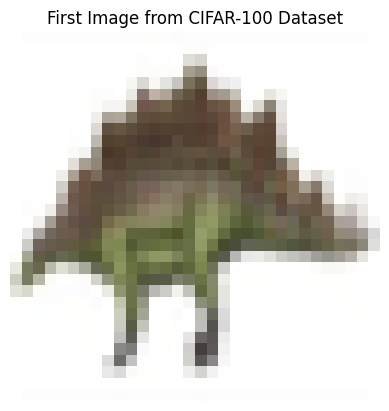

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)
# Plot the first image from the training dataset
plt.imshow(x_train[1])
plt.title('First Image from CIFAR-100 Dataset')
plt.axis('off')  # Turn off axis
plt.show()

## Uploading photos

In [9]:
def process(image):
    M, N, _ = image.shape

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')

    noise = np.random.normal(5, 50, (M, N, 3))
    img_noised = image + noise
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)

    img_noised_grey = cv2.cvtColor(img_noised, cv2.COLOR_BGR2GRAY)

    img_noised_grey_fourier = np.fft.fftshift(np.fft.fft2(img_noised_grey))
    img_noised_grey_fourier_magnitude = np.abs(img_noised_grey_fourier)

    cutoff_freq = 0.15
    rows, cols = img_noised_grey.shape
    center_row, center_col = int(rows / 2), int(cols / 2)
    x = np.linspace(0, 1, cols)
    y = np.linspace(0, 1, rows)
    X, Y = np.meshgrid(x, y)
    distances = np.sqrt((X - 0.5)**2 + (Y - 0.5)**2)
    filter_mask = distances <= cutoff_freq
    filtered_fourier = img_noised_grey_fourier * filter_mask
    filtered_image_simple = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fourier)))

    axs[1].imshow(filtered_image_simple, cmap='gray')
    axs[1].set_title('Filtered Image (Simple Low-pass)')

    cutoff_freq = 0.2
    order = 4
    nyquist_freq = 0.5
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    img_filtered_freq_butter = filtfilt(b, a, img_noised_grey)

    axs[2].imshow(img_filtered_freq_butter, cmap='gray')
    axs[2].set_title('Filtered Image (Butterworth)')

    plt.show()

    return (filtered_image_simple, img_filtered_freq_butter)

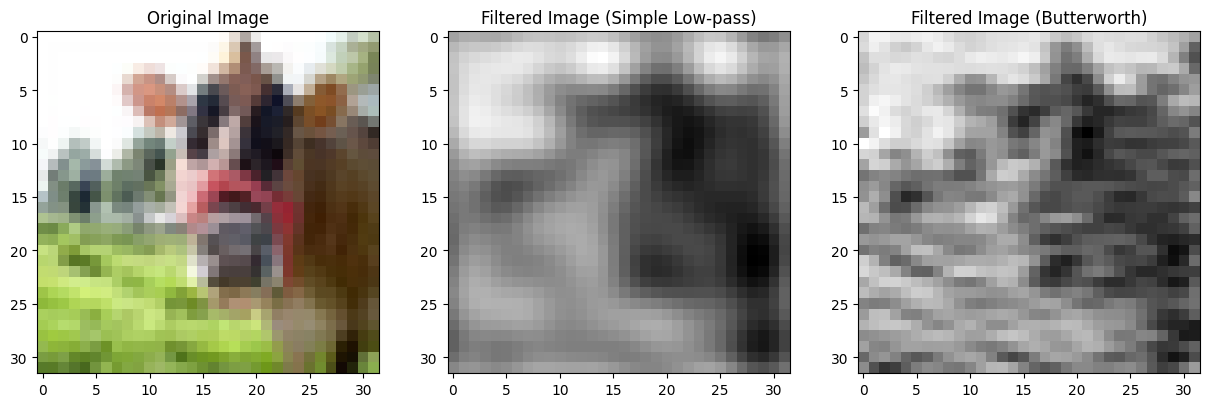

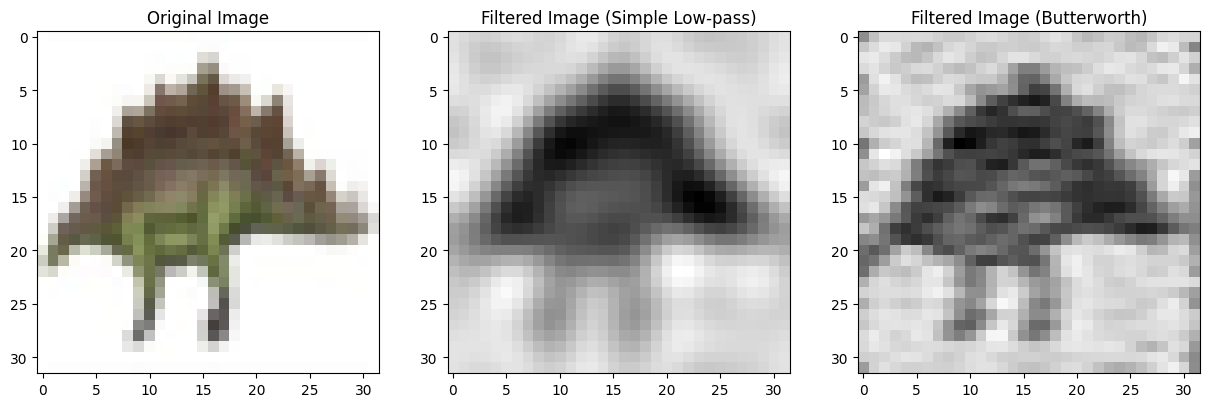

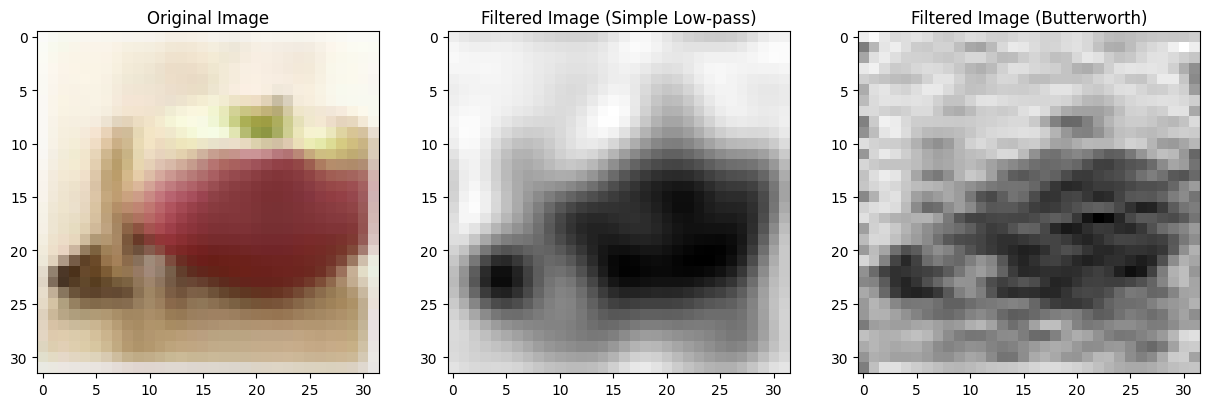

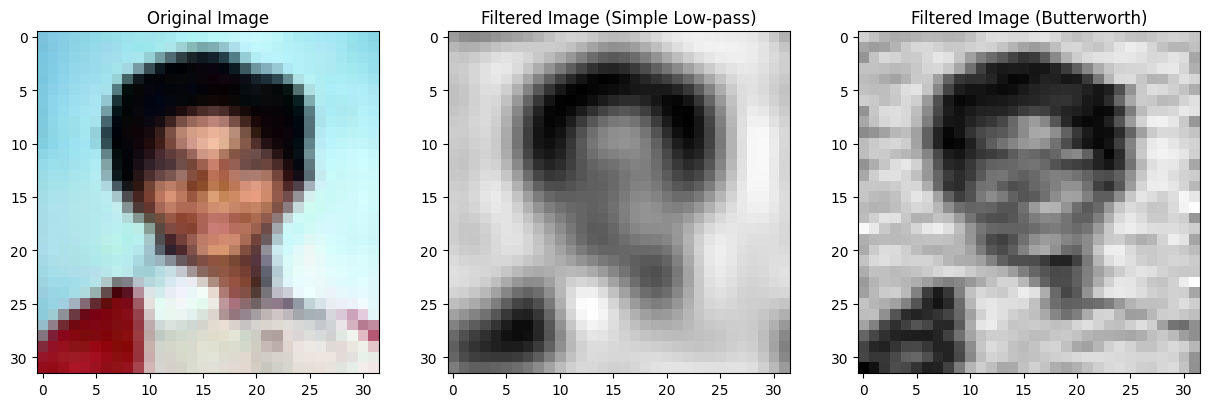

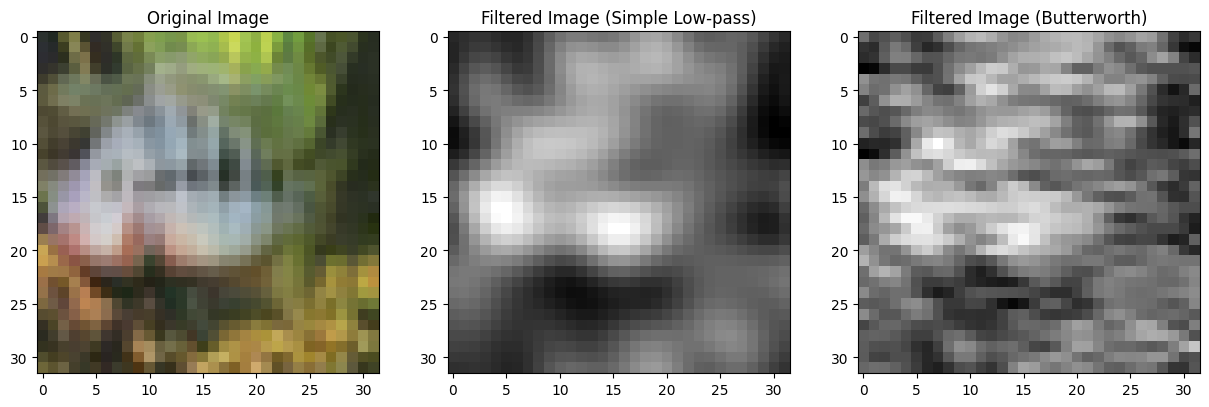

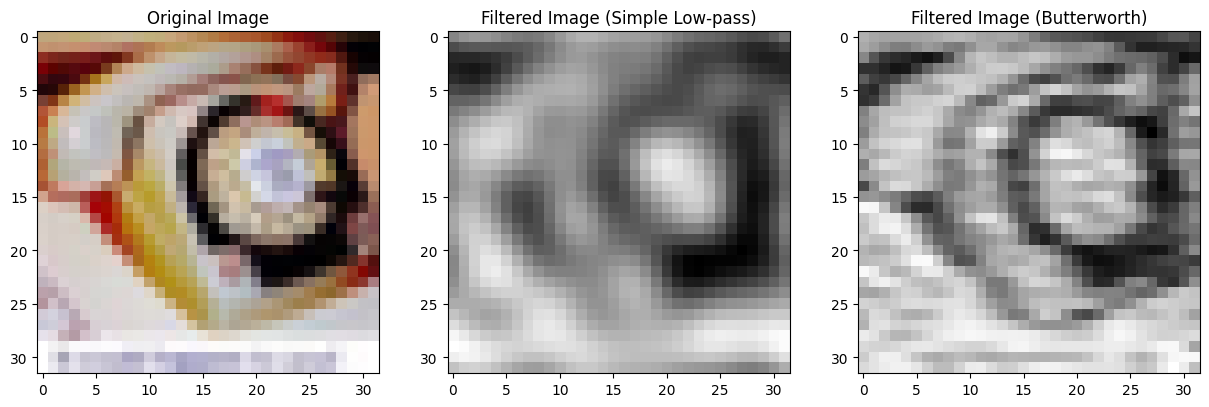

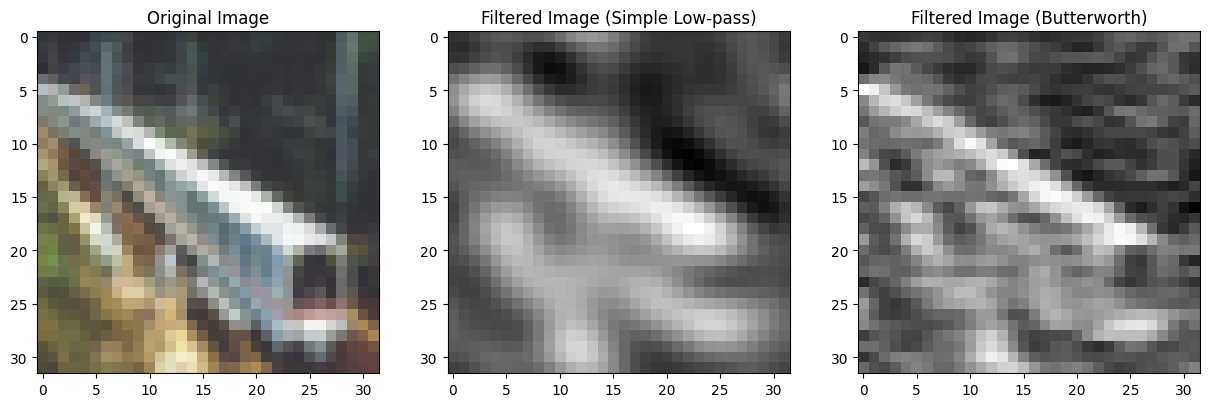

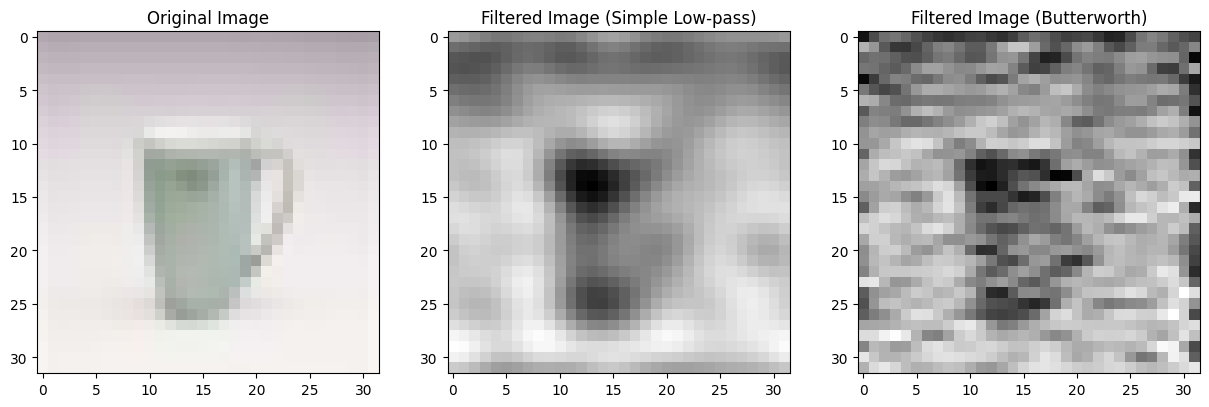

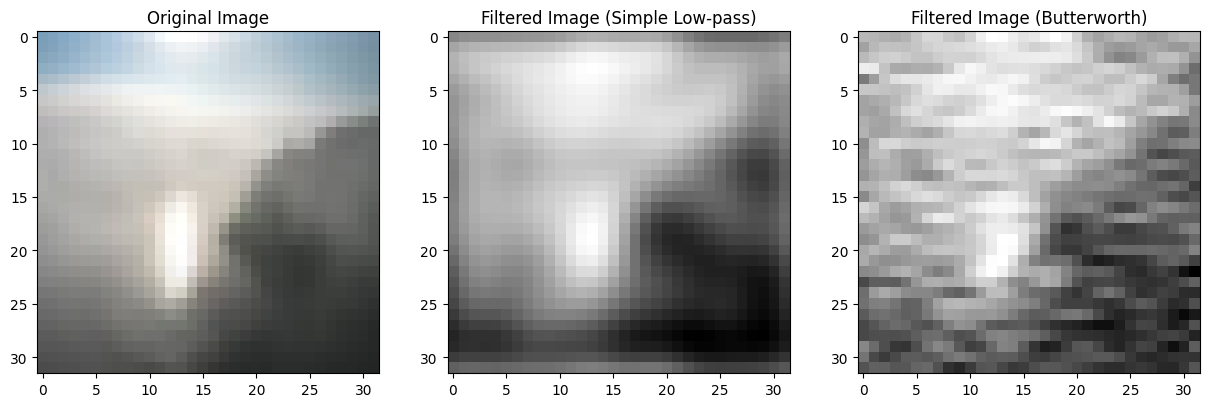

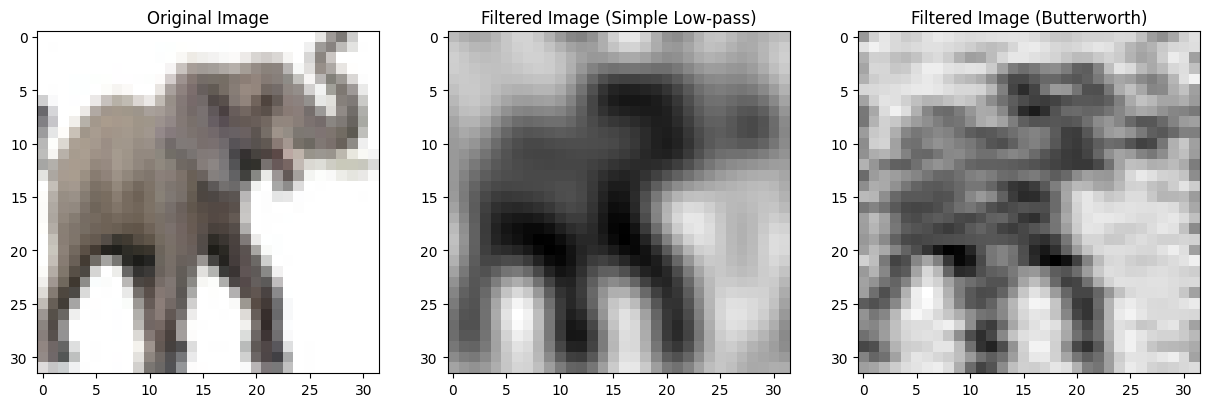

In [11]:
filtered_simple_results = []
filtered_butterworth_results = []

for image in x_train[:10]:
    filtered_simple, filtered_butterworth = process(image)

    filtered_simple_results.append(filtered_simple)
    filtered_butterworth_results.append(filtered_butterworth)


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image):
    M, N, _ = image.shape
    noise = np.random.normal(5, 50, (M, N, 3))
    img_noised = image + noise
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)
    img_noised_grey = cv2.cvtColor(img_noised, cv2.COLOR_BGR2GRAY)

    denoised_median = cv2.medianBlur(img_noised_grey,9)
    denoised_mean = cv2.blur(img_noised_grey, (9, 9))
    denoised_gaussian = cv2.GaussianBlur(img_noised_grey, (9, 9), 0)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img_noised_grey, cmap='gray')
    plt.title('Noisy Image (Grayscale)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(denoised_median, cmap='gray')
    plt.title('Denoised Image (Median Filtering)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(denoised_mean, cmap='gray')
    plt.title('Denoised Image (Mean Filtering)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(denoised_gaussian, cmap='gray')
    plt.title('Denoised Image (Gaussian Filtering)')
    plt.axis('off')

    plt.show()
    return (denoised_median, denoised_mean, denoised_gaussian)


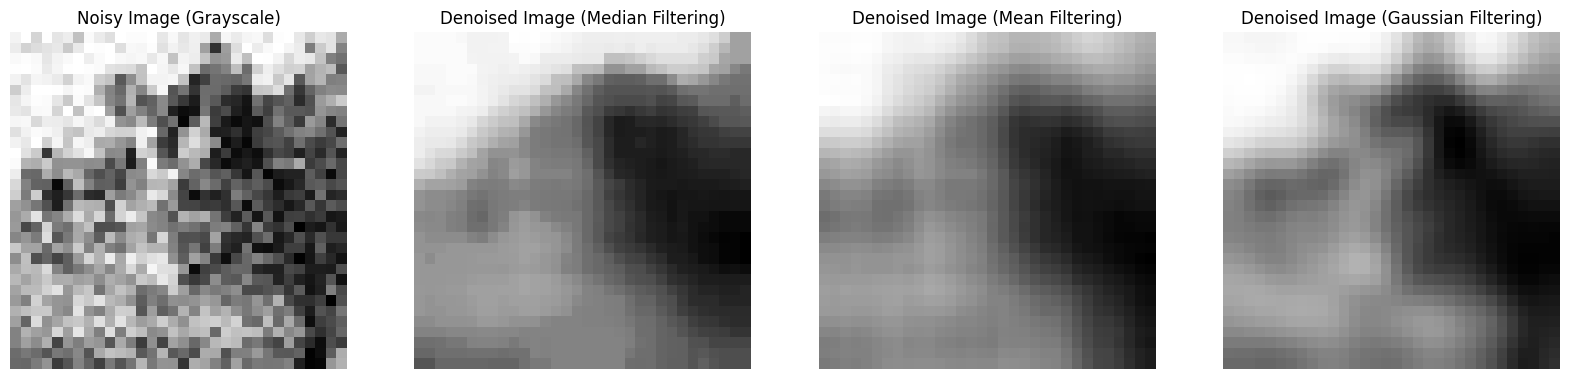

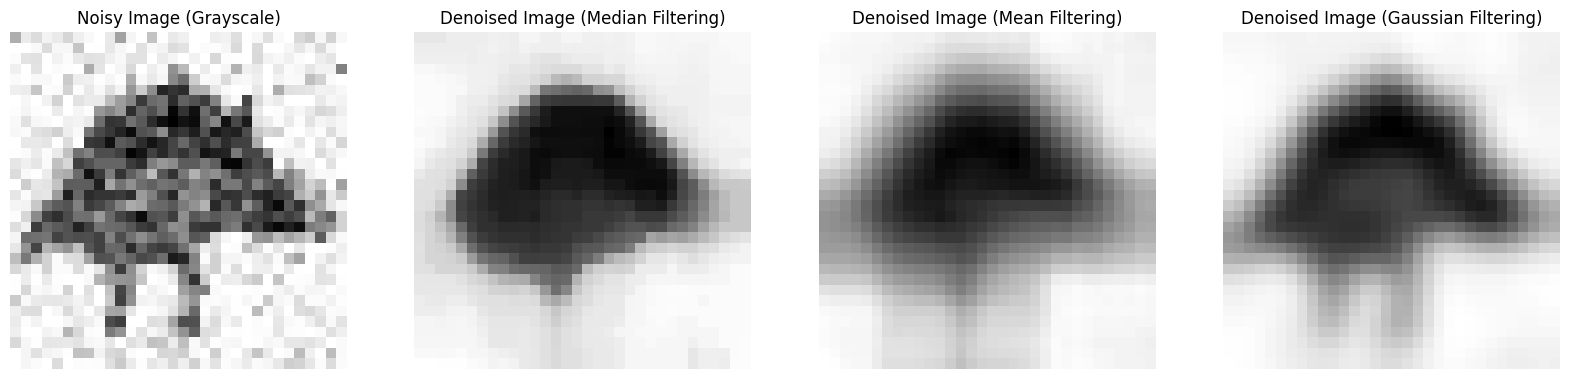

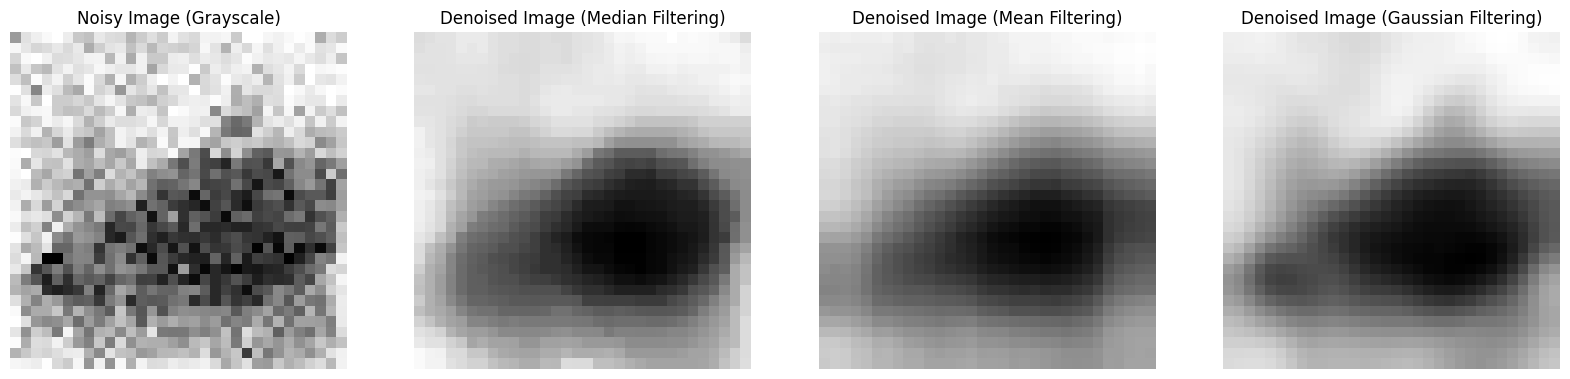

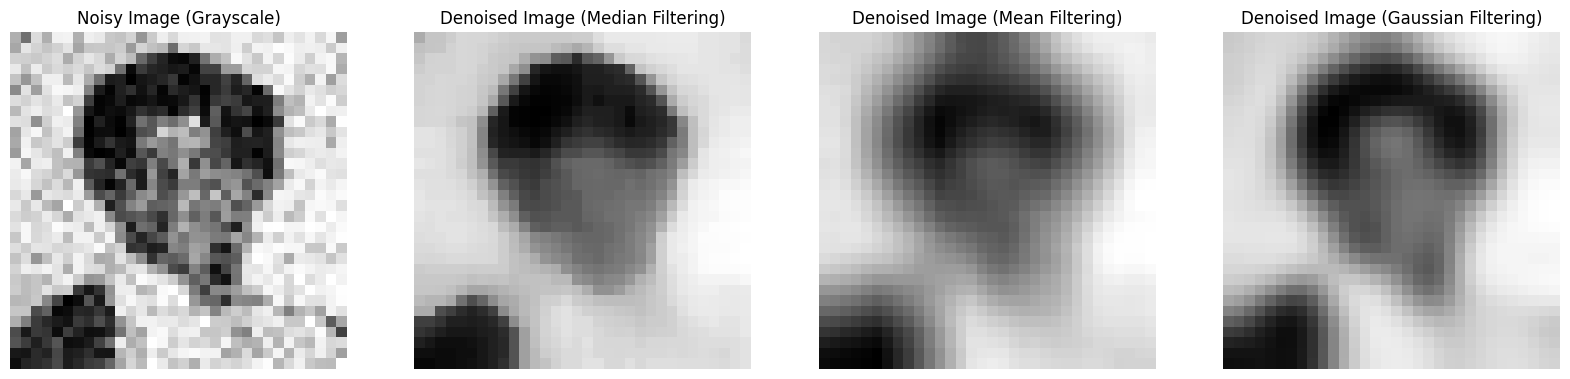

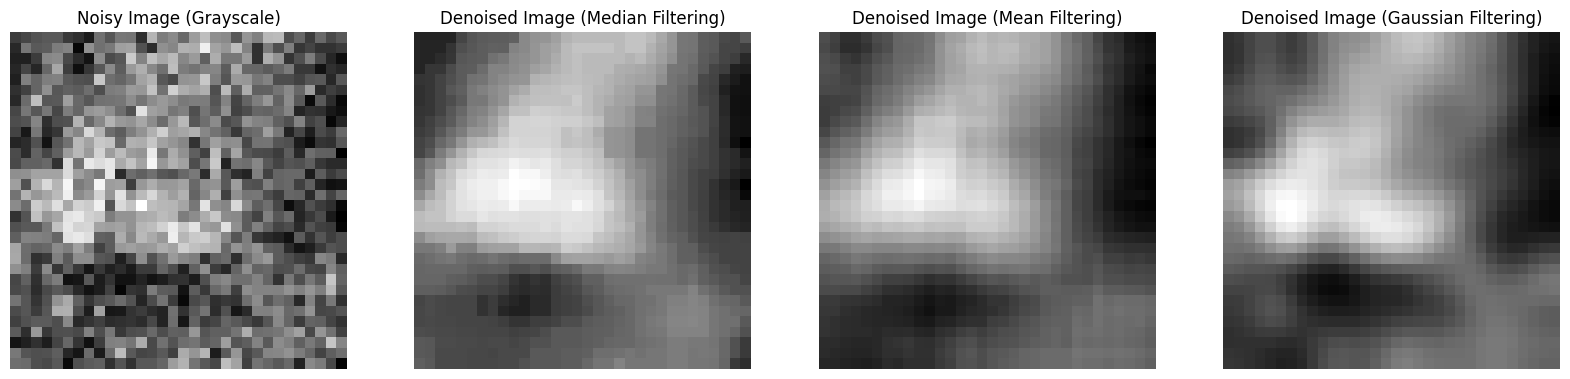

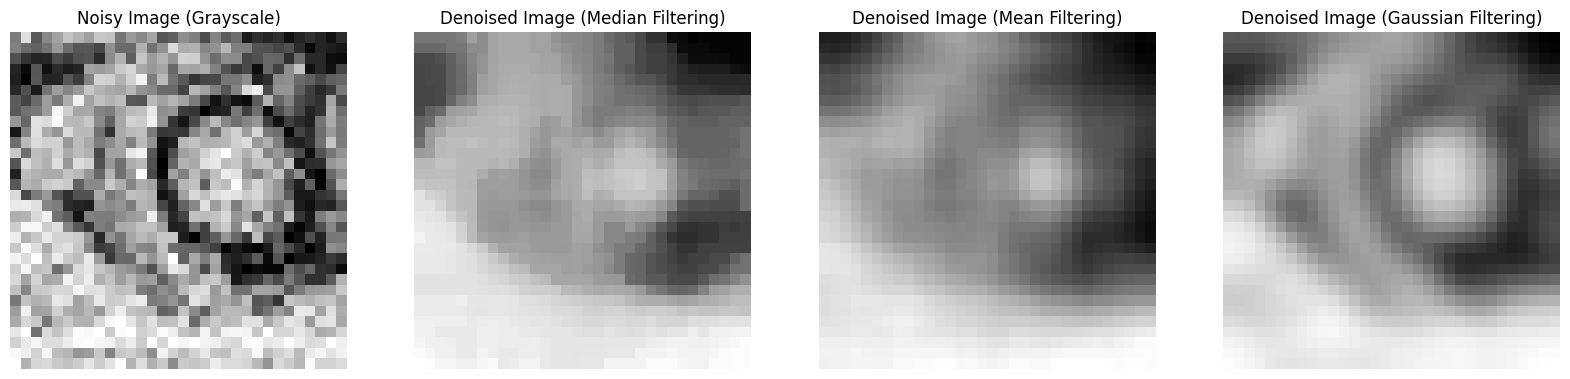

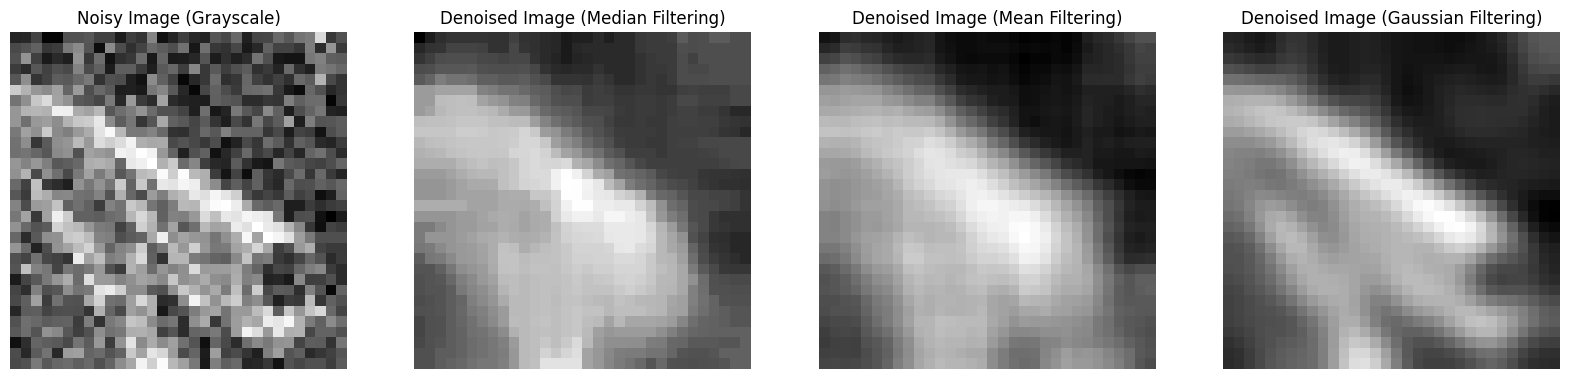

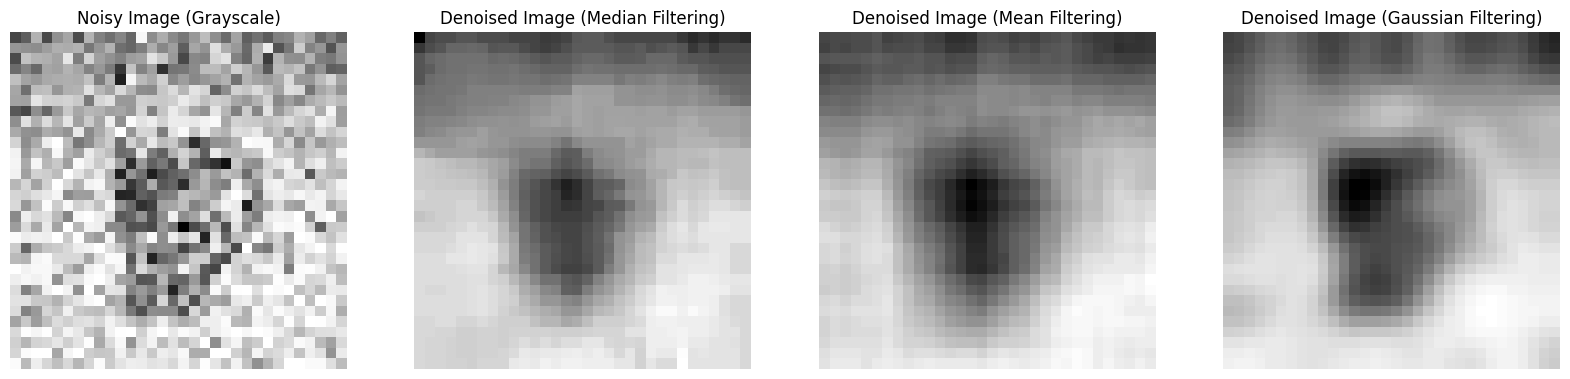

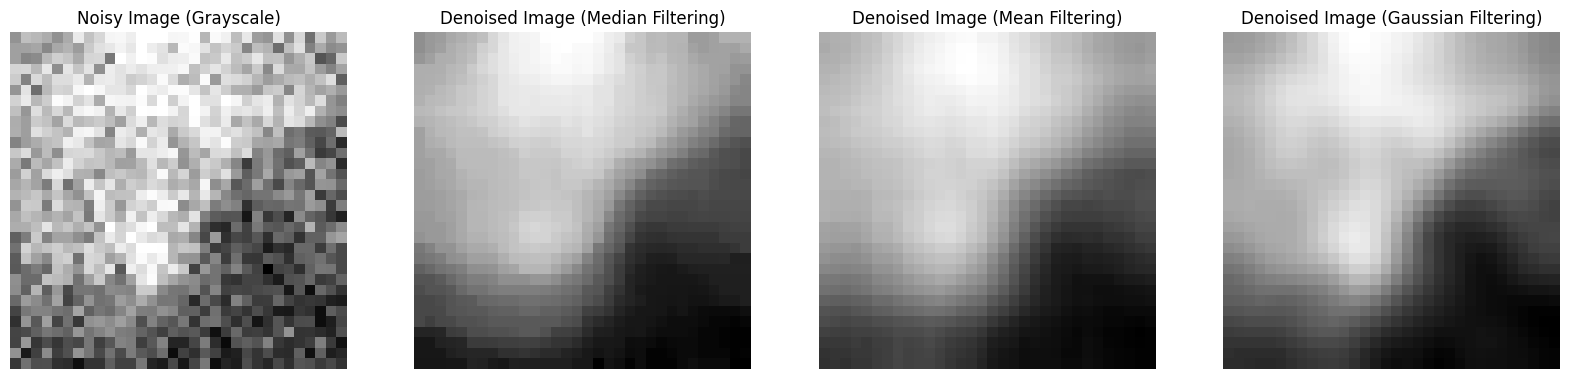

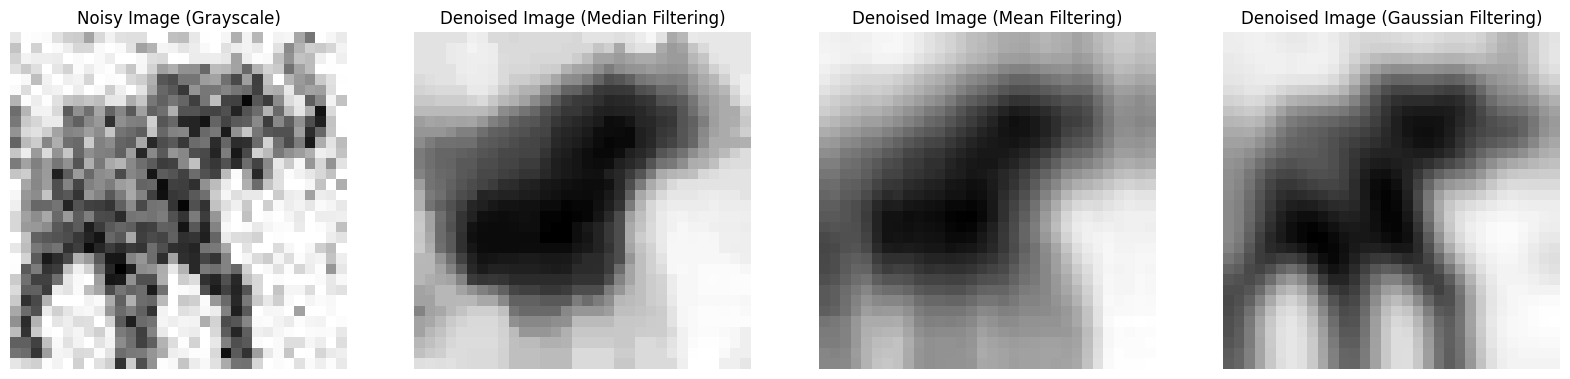

helo (32, 32, 3)
hel1 (32, 32)


In [26]:
results_median = []
results_mean = []
results_gauss = []

for image in x_train[:10]:
    median, mean, gauss = process_image(image)
    results_median.append(median)
    results_mean.append(mean)
    results_gauss.append(gauss)


In [30]:

x_train_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train[:10]]

mse_median_sp = []
mse_mean_sp = []
mse_gaussian_sp = []


mse_simple_fd = []
mse_btw_fd = []

for i in range(len(x_train_gray)):
    mse_median_sp.append(mean_squared_error(x_train_gray[i].flatten(), results_median[i].flatten()))
    mse_mean_sp.append(mean_squared_error(x_train_gray[i].flatten(), results_mean[i].flatten()))
    mse_gaussian_sp.append(mean_squared_error(x_train_gray[i].flatten(), results_gauss[i].flatten()))

    mse_simple_fd.append(mean_squared_error(x_train_gray[i].flatten(), filtered_simple_results[i].flatten()))
    mse_btw_fd.append(mean_squared_error(x_train_gray[i].flatten(), filtered_butterworth_results[i].flatten()))

print("MSE for Median Filtering Spatial Domian:")
print(mse_median_sp)
print("MSE for Mean Filtering Spatial Domian:")
print(mse_mean_sp)
print("MSE for Gaussian Filtering Spatial Domian:")
print(mse_gaussian_sp)
print("MSE for Simple Filtering Freq Domian:")
print(mse_simple_fd)
print("MSE for BTW Filtering Freq Domian:")
print(mse_btw_fd)


MSE for Median Filtering Spatial Domian:
[98.375, 104.041015625, 92.78515625, 89.8310546875, 98.0029296875, 99.4814453125, 99.0322265625, 61.599609375, 69.6953125, 95.470703125]
MSE for Mean Filtering Spatial Domian:
[97.52734375, 114.5322265625, 98.90234375, 101.5068359375, 95.9599609375, 111.0595703125, 104.822265625, 79.888671875, 75.115234375, 101.34375]
MSE for Gaussian Filtering Spatial Domian:
[101.2109375, 112.0400390625, 89.0224609375, 98.001953125, 89.125, 102.6806640625, 99.658203125, 69.029296875, 66.740234375, 100.505859375]
MSE for Simple Filtering Freq Domian:
[1052.7809433726834, 819.9648902524517, 294.16311764703744, 875.4911412735987, 382.60172090934685, 1341.486158802325, 804.9691070568997, 174.52039011084838, 381.310162859888, 972.2052077221671]
MSE for BTW Filtering Freq Domian:
[672.701510564081, 795.1928111339502, 583.9849704859275, 598.4314836442503, 562.4489108387095, 659.9350453838839, 541.040227638945, 410.1106585841718, 436.4043756227268, 872.8594032305341]


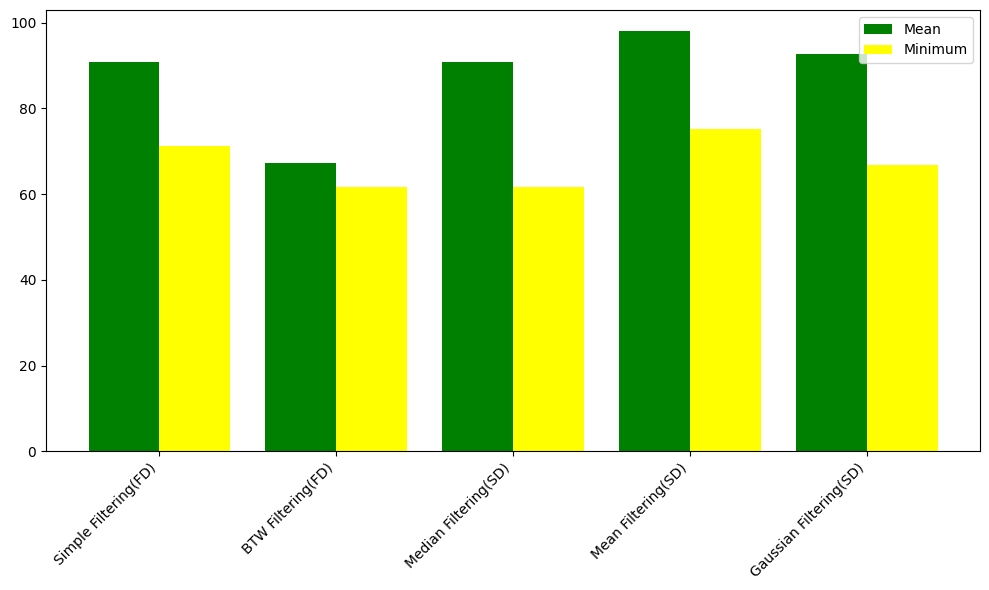

In [42]:
import numpy as np
import matplotlib.pyplot as plt

mse_simple_fd_arr = np.array(mse_simple_fd)
mse_btw_fd_arr = np.array(mse_btw_fd)
mse_median_sp_arr = np.array(mse_median_sp)
mse_mean_sp_arr = np.array(mse_mean_sp)
mse_gaussian_sp_arr = np.array(mse_gaussian_sp)

median_mean = mse_median_sp_arr.mean()
mean_mean = mse_mean_sp_arr.mean()
gaussian_mean = mse_gaussian_sp_arr.mean()
btw_mean = mse_btw_fd_arr.mean()
simple_mean = mse_simple_fd_arr.mean()

# MSE values for Simple Filtering Frequency Domain
mse_simple_fd = []

mse_simple_fd.append(simple_mean)
mse_simple_fd.append(btw_mean)
mse_simple_fd.append(median_mean)
mse_simple_fd.append(mean_mean)
mse_simple_fd.append(gaussian_mean)
# MSE values for BTW Filtering Frequency Domain
mse_btw_fd = []

min_simple_fd = mse_simple_fd_arr.min()
min_btw_fd = mse_btw_fd_arr.min()
min_median_sp = mse_median_sp_arr.min()
min_mean_sp = mse_mean_sp_arr.min()
min_gaussian_sp = mse_gaussian_sp_arr.min()

# Append the minimum values to the mse_btw_fd array
mse_btw_fd.append(min_simple_fd)
mse_btw_fd.append(min_btw_fd)
mse_btw_fd.append(min_median_sp)
mse_btw_fd.append(min_mean_sp)
mse_btw_fd.append(min_gaussian_sp)
# Labels for the functions
import numpy as np
import matplotlib.pyplot as plt

# Define the functions and labels
functions = ["Simple Filtering(FD)", "BTW Filtering(FD)", "Median Filtering(SD)", "Mean Filtering(SD)", "Gaussian Filtering(SD)"]
labels = ["Mean", "Minimum"]

# Calculate mean and minimum values for MSE
mean_values = [simple_mean, btw_mean, median_mean, mean_mean, gaussian_mean]
min_values = [min_simple_fd, min_btw_fd, min_median_sp, min_mean_sp, min_gaussian_sp]

# Bar chart settings
width = 0.4
x = np.arange(len(functions))
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars for mean values
bars_mean = ax.bar(x - width/2, mean_values, width, label="Mean", color='green')
# Plotting the bars for minimum values
bars_min = ax.bar(x + width/2, min_values, width, label="Minimum", color='yellow')

# Adding labels and titles
ax.set_xticks(x)
ax.set_xticklabels(functions, rotation=45, ha="right")
ax.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()



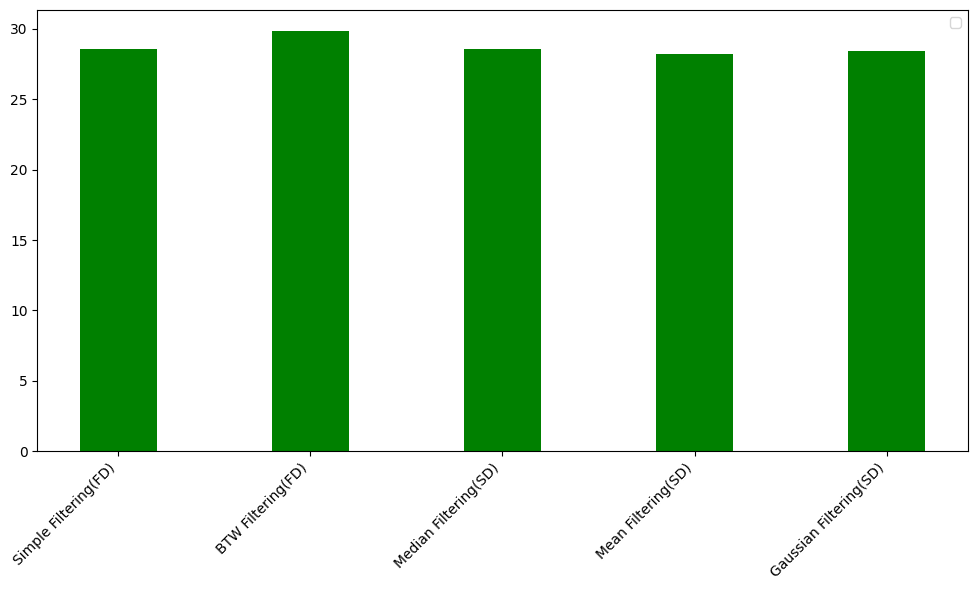

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions and labels
functions = ["Simple Filtering(FD)", "BTW Filtering(FD)", "Median Filtering(SD)", "Mean Filtering(SD)", "Gaussian Filtering(SD)"]

# Calculate MAX
MAX = 255

# Calculate PSNR for each filtering method
psnr_simple_fd_mean = 10 * np.log10((MAX**2) / mse_simple_fd_arr.mean())
psnr_btw_fd_mean = 10 * np.log10((MAX**2) / mse_btw_fd_arr.mean())
psnr_median_sp_mean = 10 * np.log10((MAX**2) / mse_median_sp_arr.mean())
psnr_mean_sp_mean = 10 * np.log10((MAX**2) / mse_mean_sp_arr.mean())
psnr_gaussian_sp_mean = 10 * np.log10((MAX**2) / mse_gaussian_sp_arr.mean())

# Construct array for mean PSNR values
mean_values_psnr = [psnr_simple_fd_mean, psnr_btw_fd_mean, psnr_median_sp_mean, psnr_mean_sp_mean, psnr_gaussian_sp_mean]

# Bar chart settings
width = 0.4
x = np.arange(len(functions))
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars for mean values
bars_mean_psnr = ax.bar(x, mean_values_psnr, width, color='green')

# Adding labels and titles
ax.set_xticks(x)
ax.set_xticklabels(functions, rotation=45, ha="right")
ax.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()
